# Gain Homogenization Offsets

D. Neise 27.07.2017

The FACT bias crate has been subject to changes recently, and thus the several needed bias crate calibration steps needed to be repeated. This document describes the last of these calibration steps, aiming to ensure a homogenous SiPM gain in the FACT camera under "closed lid" conditions. 

### preparations: 

This is analysis and documentation combined in one document, but prior to this analysis a couple of steps needed to be done:

 1. Take single-PE runs at different voltages by scheduling "OVTest" in the [FACT scheduler](https://www.fact-project.org/schedule/).
 2. Wait for the gain extraction analysis (details by T. Bretz) to be completed at ISDC.
 3. Combine the results of the analysis in a more readable file format
 
This analysis (as usual) strives to be repeatable by everyone on her laptop quickly without installing much software. This anaylsis depends on:

 * python anaconda
 * pyfact version <VERSION>
 
For step 3 however certain versions of ROOT and MARS are needed to be installed. So step 3 is prepaired outside of the scope of this document. However, no *analysis* is performed in step 3. It is just a conversion from root files to a HDF5 file in this case. So in order to make this analysis easily repeatable for you, the HDF5 file is provided along with this analysis.

### Dataset

For this analysis only single PE runs from 11.07.2017 are used. In addition the aux-file "20170711.FEEDBACK_CALIBRATED_CURRENTS.fits" is being used, as well as the "RunInfo" table from the fact database in order to assign the time based information from the aux-files to the single-PE analysis results which is available run based only.

We start as usual by importing all the needed libraries

In [1]:
from fact.credentials import create_factdb_engine
from fact.auxservices import AuxService

import pandas as pd
import fact
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm, trange

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn import linear_model

Okay, next we read in the file containing the single PE gain analysis results, but before going on with the rest of the *preparations* and the actual *analysis*, let's quickly recap the problem we are trying to solve here.

### Problem description

So the bias crate is temperature sensitive and is now running at a temperature ~5..10K different then it was before, despite having carefully done a calibration at the new temperature set point, the SiPM gain we actually measure is less homogenous than it should be. 

How homogeneous should be gain be you ask? Well, the Gain (G) is proportional to the so called over voltage:

$ G = k \cdot U_{ov} $

The over voltage is just how much over the so called breakdown voltage are we running the SiPM. The breakdown voltage is temperature dependent as well, but this effect is taken care of. Also the single PE measurement runs takes roughly 130 seconds within which the temperature of the SiPMs may be assumed to be rather stable.

$ U_{ov} = U_{SiPM} - U_{bd}(T) $

The typical over voltage can be assumed between 1 or 2 volts, let's assume 1.1 volt.
We can control the actually applied voltage $U_{SiPM}$ with a resolution of 22mV. So we should be able to control the gain in steps of 2%. 

Now let's have a look at the inhomogeneity, we actually observe in a single example run.

In [2]:
df = pd.read_hdf('spe_20170711.h5')
df.sample()  # one example entry

,date,run_id,CHID,Gain
206882,2017-07-11,40,678,228.117798


In [3]:
example_run_id = 14
G = df[df.run_id == example_run_id].sort_values('CHID').Gain

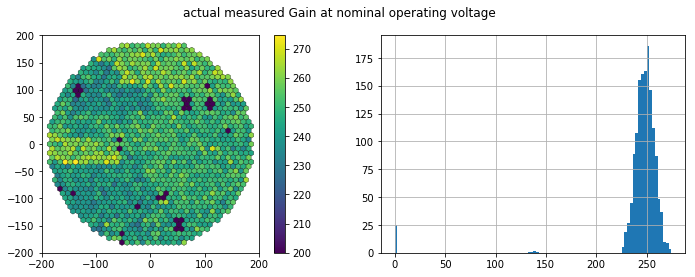

In [4]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    G, 
    cmap='viridis',
    ax=left,
    vmin=200,
)
plt.colorbar(img, ax=left)

G.hist(ax=right, bins=100)

plt.suptitle('actual measured Gain at nominal operating voltage');

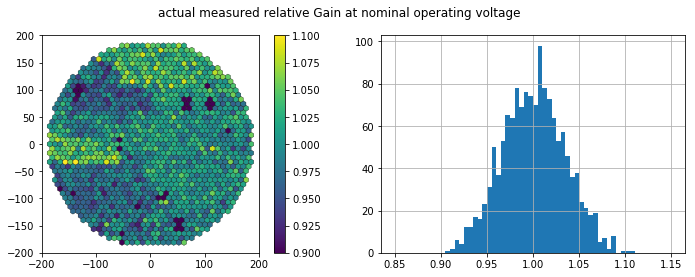

In [5]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    G/G.median(), 
    cmap='viridis',
    ax=left,
    vmin=0.9,
    vmax=1.1,
)
plt.colorbar(img, ax=left)

(G/G.median()).hist(ax=right, range=[0.85, 1.15], bins=60)

plt.suptitle('actual measured relative Gain at nominal operating voltage');

In [6]:
p = fact.instrument.get_pixel_dataframe()[['CHID', 'bias_patch_id']]
df['bias_patch_id'] = p.bias_patch_id.values[df.CHID]
df.sample()

,date,run_id,CHID,Gain,bias_patch_id
190927,2017-07-11,21,629,231.85199,123


In [7]:
example_run_id = 14
run = df[df.run_id == example_run_id]
run = run.groupby('bias_patch_id').median()[['Gain']]
run.reset_index(inplace=True)
G = pd.merge(run, p).sort_values('CHID').Gain

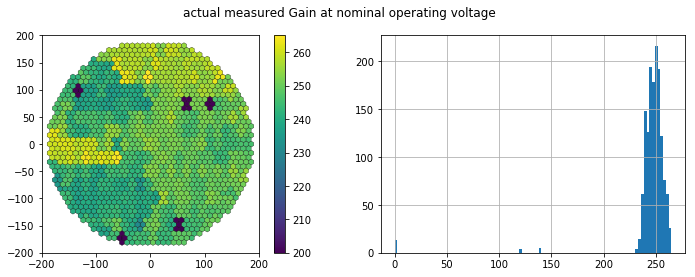

In [8]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    G, 
    cmap='viridis',
    ax=left,
    vmin=200,
)
plt.colorbar(img, ax=left)

G.hist(ax=right, bins=100)

plt.suptitle('actual measured Gain at nominal operating voltage');

So maybe one can see the problem best in the plot below showing the median bias patch gain (actually the relative gain). On the right side the blue histogram shows the relative gain in bins of width 2%, so in principle it should be possible to press all the bias patches into the central bin of width 2%.

And this is what we plan to achieve with the voltage offsets gained from this analysis

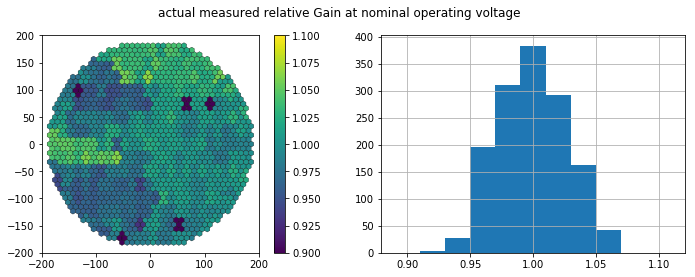

In [9]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    G/G.median(), 
    cmap='viridis',
    ax=left,
    vmin=0.9,
    vmax=1.1,
)
plt.colorbar(img, ax=left)

right.hist(
    G / G.median(),
    bins=np.arange(0.9-0.01, 1.1+0.01, 0.02)
)
right.grid()

plt.suptitle('actual measured relative Gain at nominal operating voltage');

-----

We go on preparing the input to our analysis. We need some information about the applied voltage at each run. For this we need each runs start and stop time. So we request the start and stop times for all runs from our `RunInfo` database and merge that information into our table, so we can assign aux-file time based information. (This might ask for a password in your case, depending on your local setup). 

In [10]:
runinfo = pd.read_sql(
    'select fNight, fRunID, fRunStart, fRunStop from RunInfo', 
    create_factdb_engine()
)
df['night_int'] = df.date.dt.strftime('%Y%m%d').astype(int)
df = pd.merge(df, runinfo, left_on=['night_int', 'run_id'], right_on=['fNight','fRunID'])
df.drop(['fNight', 'fRunID', 'night_int'], axis=1, inplace=True)

df.sample()

,date,run_id,CHID,Gain,bias_patch_id,fRunStart,fRunStop
5067,2017-07-11,17,596,157.680359,116,2017-07-11 20:30:03,2017-07-11 20:32:13


Next we open the aux-file containing `U_ov`, which is the "Calculated overvoltage w.r.t. operation voltage" in volts, as stated inside [feedback.cc](https://trac.fact-project.org/browser/trunk/FACT%2B%2B/src/feedback.cc#L1215). 

Then we loop over all runs in our big table and assign the average (median is used here to estimate the average) overvoltage (`U_ov`) to each bias patch.

After we assigned `U_ov` to each run, we do not need the start and stop time anymore so let's drop it again, to keep the table nicely small. 

On my machine this took ~10 seconds, so please be patient...

In [11]:
fb_cur = AuxService.read_file('20170711.FEEDBACK_CALIBRATED_CURRENTS.fits')
fb_cur['Time'] = pd.to_datetime(fb_cur.Time, unit='d')
fb_cur.set_index('Time', inplace=True)
fb_cur.sort_index(inplace=True)

for __, run in df.groupby(['date', 'run_id']):
    start_time = run.fRunStart.iloc[0]
    stop_time = run.fRunStop.iloc[0]
    run_fb_cur = fb_cur[start_time:stop_time].median()
    U_ov = np.array([
        run_fb_cur['U_ov_'+str(i)] for i in range(320)
    ])
    
    for bias_patch_id in range(320):
        df.set_value(
            run[run.bias_patch_id == bias_patch_id].index, 
            'U_ov', 
            U_ov[bias_patch_id]
        )

df.drop(['fRunStart', 'fRunStop'], axis=1, inplace=True)
df.sample()

,date,run_id,CHID,Gain,bias_patch_id,U_ov
29296,2017-07-11,42,523,274.329742,100,0.192926


In principle we have everything ready to start, but let's take a quick look at what we actually did.

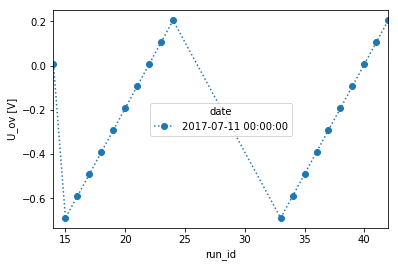

In [12]:
average_per_run = df.groupby(['date', 'run_id']).mean()
average_per_run.unstack(level=0).U_ov.plot(linestyle=':', marker='o')
plt.ylabel('U_ov [V]');

Aha .. so there was one single PE run (number 14) at nominal voltage, that is the reason we used it above, to explain the actual problem. 

Then we have two OVtest runs, one consisting of the single pe runs 15 .. 24 and another one containing single pe runs 33 .. 42. All where taken at the same day. In principle the code below is written, so it can work on OVtest runs taken on several different days. But above the part where the aux-file is read in .. well it only reads in a single aux file. This part needs to be generalized in case you would like to analysze data from several different days.

Ok .. so we have the `Gain` and the over voltage `U_ov` per pixel or per bias patch, whatever we like better. Now we can go through all bias patches and plot the gain versus the over voltage and make a fit. 

Since I have already done it, I know there are a lot of outliers, either because one pixel in a bias patch is broken and gives very small gain only, or because the gain extraction algorithm was not able to extract the gain exactly, I don't know. So for the fitting, we use a more robust estimator [Ransac](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).

I tried it, but I found that some bias patches contain so many outliers, that the estimator fits the outlier population and not the real population, so within the fit routine below, I actually gut away all points, with a gain, less than 20% of the nominal gain. 

In case you ever looked at FACT raw data single pe events, you might remember that a single pe pulse is about 10mV high and the noise level is in the range of 2mV. So in case the was really only 20% of the nominal gain, the gain extractor would have a very hard time finding these tiny pulses. Thus it is reasonable to cut away these points.

In [13]:
def fit_gain_vs_U_ov(run):
    model = linear_model.RANSACRegressor(
        linear_model.LinearRegression()
    )
    run_for_fit = run[run.Gain > 50]
    X = run_for_fit.U_ov.values[:, None]
    y = run_for_fit.Gain.values
    model.fit(X, y)
    return model

Now .. below I prepared an interactive plot where you can move the slider to see how the fit looks for any of the 320 different bias patched. I actually did this to ensure all fits look reasonable. 

In case you are looking at the PDF version, then you see only an example for bias_patch number 193 which is a particularly bad patch, with a lot of outliers.

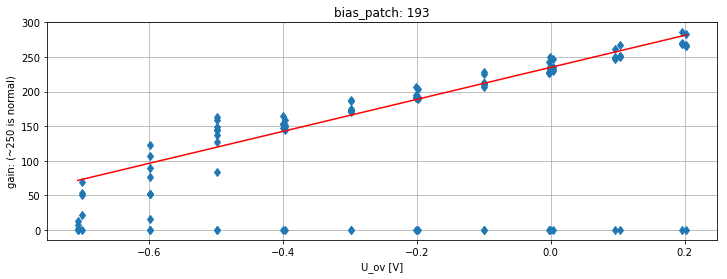

In [14]:
@interact(bias_patch=widgets.IntSlider(min=0, max=319, value=193))
def plot_gain_vs_U_ov_per_bias_patch(bias_patch):
    plt.figure(figsize=(12, 4))
    run = df[df.bias_patch_id == bias_patch]
    plt.plot(run.U_ov, run.Gain, 'd')
    plt.xlabel('U_ov [V]')
    plt.ylabel('gain: (~250 is normal)')
    plt.grid()
    plt.title('bias_patch: '+str(bias_patch))
    
    linx_X = np.linspace(run.U_ov.min(), run.U_ov.max(), 10)
    plt.plot(
        linx_X,
        fit_gain_vs_U_ov(run).predict(linx_X[:, None]),
        'r-'
    )

Below you see the loop, that is actually doing all the fits and storing them in the table called `fits`. We also see some sample results.

In [15]:
fits = []
for bias_patch in range(320):
    run = df[df.bias_patch_id == bias_patch]
    try:
        m = fit_gain_vs_U_ov(run)
        fits.append({
            'bias_patch_id': bias_patch,
            'slope': m.estimator_.coef_[0],
            'intercept': m.estimator_.intercept_
        })
    except:
        fits.append({
            'bias_patch_id': bias_patch,
            'slope': np.nan,
            'intercept': np.nan
        })
fits = pd.DataFrame(fits)
fits = pd.merge(p, fits)

fits.head(12)

,CHID,bias_patch_id,intercept,slope
0,0,0,257.108835,193.087091
1,1,0,257.108835,193.087091
2,2,0,257.108835,193.087091
3,3,0,257.108835,193.087091
4,4,1,258.531652,186.958392
5,5,1,258.531652,186.958392
6,6,1,258.531652,186.958392
7,7,1,258.531652,186.958392
8,8,1,258.531652,186.958392
9,9,2,258.033634,193.962177


----

## Results

Now all we can do is look at the fit results. Below we see the intercept of the fit, i.e. the Gain at the nominal voltage as it is extracted from the fits. We would naively assume it to look very similar to the plot in Box number 8, and indeed there is some similarity.

/home/dneise/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


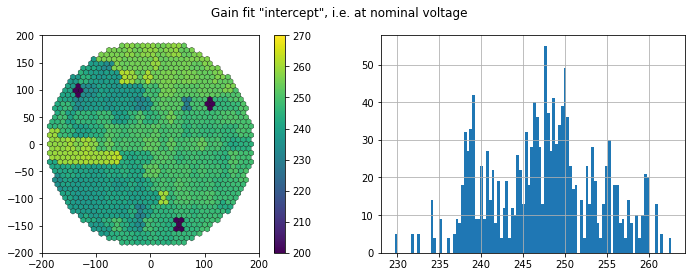

In [16]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    fits.intercept, 
    cmap='viridis',
    vmin=200,
    vmax=270,
    ax=left
)
plt.colorbar(img, ax=left)

fits.intercept.hist(ax=right, bins=100)

plt.suptitle('Gain fit "intercept", i.e. at nominal voltage');

Below we see the slope of the fits. The nominal gain in FACT has a value of about 250 mV$\cdot$slices. The median change in gain per volt over voltage is ~187 (mV$\cdot$slices / V). So indeed, it turns out, if we want to change the gain by about 2% of its value, we need to alter the over voltage by about 27mV, which is the resolution of the FACT bias supply.

/home/dneise/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


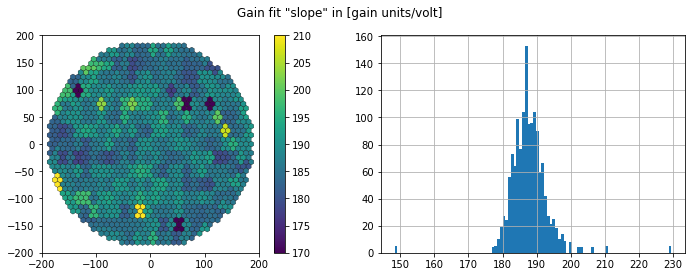

In [17]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    fits.slope, 
    cmap='viridis',
    ax=left,
    vmin=170,
    vmax=210,
)
plt.colorbar(img, ax=left)

fits.slope.hist(ax=right, bins=100)

plt.suptitle('Gain fit "slope" in [gain units/volt]');

Below I think we see something interesting. From the intercept and the slope we can calculate at which over voltage The SiPMs in FACT are actually running. As I wrote above, the gain is around 250 mVslices, but it could as well be chosen to be around 260mVslices. This just changes the over voltage we are running at. Or the other way around. We choose the over voltage we want to run at, and then live with the gain we get there. 

At the moment we see a median over voltage of 1.32V 

/home/dneise/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


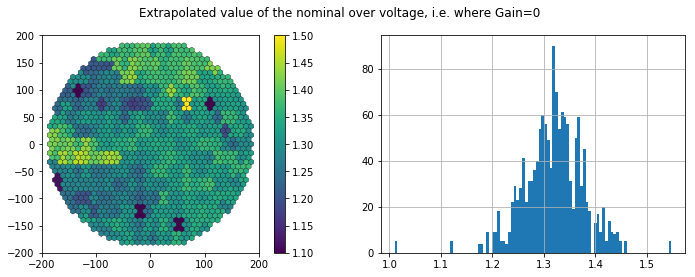

In [18]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = fact.plotting.camera(
    fits.intercept/fits.slope, 
    cmap='viridis',
    ax=left,
    vmin=1.1,
    vmax=1.5,
)
plt.colorbar(img, ax=left)

(fits.intercept/fits.slope).hist(ax=right, bins=100)

plt.suptitle('Extrapolated value of the nominal over voltage, i.e. where Gain=0');

--------------

## Application

So as a last step, we have to calculate some offsets and put them in a file for the `feedback` program to read it in. At the moment the file is called "gapd-offset-20140321.txt" and it can be found somewhere on La Palma. We do not have it checked into our SVN, for reasons I can not understand at all, instead we have a DB entry, that states the name of the file.... smart hu? Yes ... very.

let's have a look at the first few lines to get a feeling for its layout

In [19]:
!head gapd-offset-20140321.txt

-0.020431
0.00832178
0.0212958
0.0104781
0.0430267
0.0319688
0.035354
0.00926146
-0.00976893
0.00909934


In [20]:
!wc -l gapd-offset-20140321.txt

320 gapd-offset-20140321.txt


Aha ... so it is a single column text file without a header, containing offsets. I assume these offsets are stored in volts, so the numbers are precise to the $\mu$V, while our voltage supply has a resolution in the order of 20mV.

Anyway let's read the current version in.

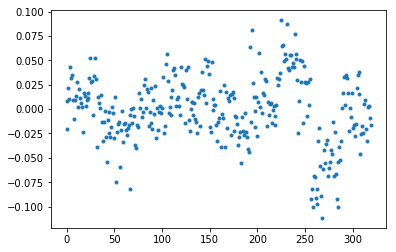

In [21]:
old_offsets = np.genfromtxt('gapd-offset-20140321.txt')
plt.plot(old_offsets, '.');

Now. We say the fit intercept is our best estimate of the bias patch gain *at nominal operation voltage*. So let's (for the moment at least, define the median of all intercepts, as our "goal_gain". 

In [22]:
fits = fits.groupby(fits.bias_patch_id).mean()[['intercept', 'slope']]
goal_gain = fits.intercept.median()

Now we just calculate the offset (in volts) needed for each patch to reach that "goal gain"

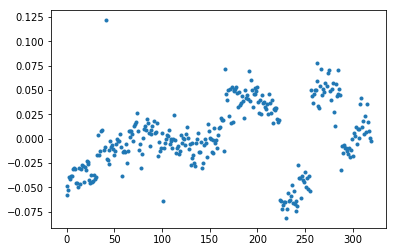

In [23]:
fits['needed_offset'] = (goal_gain - fits.intercept) / fits.slope
plt.plot(fits['needed_offset'], '.');

We see bias patch 41 which has an offset larger than 0.5V. This patch is clearly misbehaving, so we should not apply any value here.

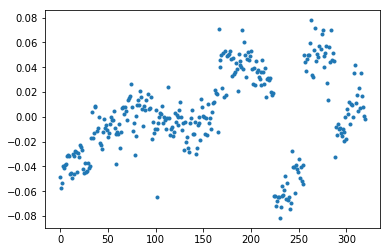

In [24]:
fits.set_value(41, 'needed_offset', 0.)
plt.plot(fits['needed_offset'], '.');

These offsets look reasonable to the ones we had before. So now, all we need to do, is either **add or subtract** these offsets, to the ones we already have and write the numbers into a file.
Since we don't know the sign, I will write two files and try both. 

One will make the homogeneity better ... the other will worsen it.

Then I will update this study to pretend I knew the answer already before trying and call it a day.

Cheers

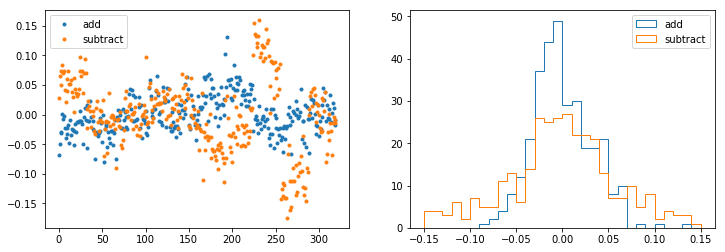

In [25]:
fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
left.plot(old_offsets + fits.needed_offset, '.', label='add')
left.plot(old_offsets - fits.needed_offset, '.', label='subtract')
left.legend()

right.hist(old_offsets + fits.needed_offset, bins=np.linspace(-0.15, 0.15, 31), range=[-0.15, 0.15], histtype='step', label='add')
right.hist(old_offsets - fits.needed_offset, bins=np.linspace(-0.15, 0.15, 31), range=[-0.15, 0.15], histtype='step', label='subtract')
right.legend();

I think it is interesting, that one for the new offsets ('add') shows actually pretty low values. It almost creates the impression, that the offsets, we are operating with, since 2014, are actually a bit too large.

So I start tonight with "add"

In [26]:
add = old_offsets + fits.needed_offset
add[add.isnull()] = 0.
add.to_csv(path='gapd-offset-20170727_add.txt', index=False, float_format='% .3f')

In [27]:
!head gapd-offset-20170727_add.txt

-0.069
-0.049
-0.032
-0.029
 0.001
-0.007
-0.003
-0.022
-0.040
-0.022


 * I copied this file to newdaq:operation/. 
 * modified the config DB accordingly and 
 * restarted `Feedback`

So let's tomorrow have a look at the 2 single pe runs, which are taken normally per night.